<a href="https://colab.research.google.com/github/kibenjenga/Data-Visualizatio/blob/main/Machine_Learning_COM7022_%5B4037%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries Utilized for the Process**

In [1]:
!pip install fuzzywuzzy python-Levenshtein --quiet
!pip install rapidfuzz --quiet

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Clustering
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram # Added dendrogram to this import

# t-SNE
from sklearn.manifold import TSNE

# Text (for minor title cleaning)
from fuzzywuzzy import fuzz, process
import warnings
sns.set(style="whitegrid", font_scale=1.1)
%matplotlib inline
warnings.filterwarnings('ignore')

**Load Dataset**

In [3]:
df = pd.read_csv("/content/Fragrance Dataset - COM7022 - [4037].csv")

**Data Preprocessing Before cleaning**

In [4]:
df.head(5)

,brand,title,type,price,priceWithCurrency,available,availableText,sold,lastUpdated,itemLocation
0,Dior,Christian Dior Sauvage Men's EDP 3.4 oz Fragra...,Eau de Parfum,84.99,US $84.99/ea,10.0,More than 10 available / 116 sold,116.0,"May 24, 2024 10:03:04 PDT","Allen Park, Michigan, United States"
1,AS SHOW,A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...,Eau de Parfum,109.99,US $109.99,8.0,8 available / 48 sold,48.0,"May 23, 2024 23:07:49 PDT","Atlanta, Georgia, Canada"
2,Unbranded,HOGO BOSS cologne For Men 3.4 oz,Eau de Toilette,100.00,US $100.00,10.0,More than 10 available / 27 sold,27.0,"May 22, 2024 21:55:43 PDT","Dearborn, Michigan, United States"
3,Giorgio Armani,Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...,Eau de Toilette,NaN,US $44.99/ea,2.0,2 available / 159 sold,159.0,"May 24, 2024 03:30:43 PDT","Reinholds, Pennsylvania, United States"
4,Lattafa,Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...,Fragrances,16.91,US $16.91,NaN,Limited quantity available / 156 sold,156.0,"May 24, 2024 07:56:25 PDT","Brooklyn, New York, United States"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              999 non-null    object 
 1   title              1000 non-null   object 
 2   type               997 non-null    object 
 3   price              996 non-null    float64
 4   priceWithCurrency  1000 non-null   object 
 5   available          889 non-null    float64
 6   availableText      997 non-null    object 
 7   sold               994 non-null    float64
 8   lastUpdated        947 non-null    object 
 9   itemLocation       1000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 78.3+ KB


In [6]:
df.describe()

,price,available,sold
count,996.000000,889.000000,994.000000
mean,46.497279,20.046119,766.266600
std,35.590865,61.547985,3200.971733
min,3.000000,2.000000,1.000000
25%,22.990000,5.000000,14.000000
50%,35.710000,10.000000,49.500000
75%,59.000000,10.000000,320.500000
max,259.090000,842.000000,54052.000000


In [7]:
df.isnull().sum()

,0
brand,1
title,0
type,3
price,4
priceWithCurrency,0
available,111
availableText,3
sold,6
lastUpdated,53
itemLocation,0


**Data Cleaning and Processing**

Fixing the Date Column

In [8]:
# Remove timezone abbreviations like PDT, PST, etc.
df['lastUpdated'] = df['lastUpdated'].astype(str).str.replace(r'\s+[A-Z]{2,4}$', '', regex=True)
df['lastUpdated'] = pd.to_datetime(df['lastUpdated'], errors='coerce')
df = df.sort_values('lastUpdated')

Fix Price Column

In [9]:
# Fill in missing values in the 'price' column of the DataFrame, with information from the 'priceWithCurrency' column.

def extract_price(row):
  if pd.isna(row['price']):
        price_str = row['priceWithCurrency']


        match = re.search(r'\d+\.?\d*', price_str)
        if match:
            return float(match.group(0))
  return row['price']

# Applying the function to fill missing 'price' values

df['price'] = df.apply(extract_price, axis=1)

# Log-transform price
df['log_price'] = np.log1p(df['price'])


# Checking the number of missing values in 'price' after extraction
print("Missing values in 'price' after extraction:")
print(df['price'].isnull().sum())

Missing values in 'price' after extraction:
0


Fix Type Column

In [10]:
# Fill in missing values in the 'type' column of the DataFrame, with information from the 'title' column.

def fill_missing_type(row):
    if pd.isna(row['type']):
        title = str(row['title']).lower()
        if 'edp' in title:
            return 'eau de parfum'
        elif 'edt' in title:
            return 'eau de toilette'
        elif 'cologne' in title:
            return 'cologne'
    return row['type']

# Apply the function to fill missing 'type' values
df['type'] = df.apply(fill_missing_type, axis=1)

# Check the number of missing values in 'type' after filling
print("Missing values in 'type' after filling:")
print(df['type'].isnull().sum())

Missing values in 'type' after filling:
1


Fix Available Column

In [11]:
# Fill in missing values in the 'available' column of the DataFrame, with information from the 'availableText' column.
def extract_available(row):
    if pd.isna(row['available']):
        available_str = str(row['availableText']).lower()  # Convert to lowercase for easier matching
        if 'more than' in available_str or 'available' in available_str:
            # Extract the number before 'available' or 'sold'
            match = re.search(r'(\d+)\s*available', available_str)
            if match:
                return int(match.group(1))
            match = re.search(r'(\d+)\s*sold', available_str)
            if match:
                # If only sold info is available and available is missing, assume 0 available
                return 0
        elif 'last on' in available_str:
            return 1
        elif 'limited quantity available' in available_str:
            # If "limited quantity available" is present and 'available' is missing,
            # fill with the mean of 'available' for that 'type'
            return df.groupby('type')['available'].transform('mean').loc[row.name]

    return row['available']

# Apply the function to fill missing 'available' values
df['available'] = df.apply(extract_available, axis=1)

# Check the number of missing values in 'available' after extraction
print("Missing values in 'available' after extraction:")
print(df['available'].isnull().sum())

Missing values in 'available' after extraction:
3


Fixing the Sold Column

Fixing Brand Column

In [12]:
# CLEAN TEXT FUNCTION
def clean_brand_name(name):
   # Normalizing brand name by lowercasing, stripping, and removing special characters.
    if pd.isna(name):
        return None
    name = str(name).lower().strip()
    name = re.sub(r'[^a-z\s&]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

df['brand_clean'] = df['brand'].apply(clean_brand_name)


# HANDLE KNOWN BRAND ALIASES
brand_aliases = {
    'christian dior': 'dior',
    'maison dior': 'dior',
    'dior homme': 'dior',
    'ysl': 'yves saint laurent',
    'ysl beauty': 'yves saint laurent',
    'tom ford beauty': 'tom ford',
    'giorgio armani beauty': 'armani',
    'dolce gabbana': 'dolce & gabbana',
    'd & g': 'dolce & gabbana',
    'ck': 'calvin klein',
    'calvin klein perfumes': 'calvin klein',
    'lancome paris': 'lancome',
    'lancôme': 'lancome',
    'paco rabane': 'paco rabanne',
    'hermes paris': 'hermes',
    'bvlgari': 'bulgari',
    'elizabeth arden new york': 'elizabeth arden'
}

df['brand_clean'] = df['brand_clean'].replace(brand_aliases)



Adding a column representing the volumes in ML from the title  column doing research about perfume

In [13]:
#VOLUME IN ML (from title)

def get_ml(title):
    if pd.isna(title): return np.nan
    m = re.search(r'(\d+\.?\d*)\s*(oz|ml|fl ?\.?oz)', str(title), re.I)
    if not m: return np.nan
    val = float(m.group(1))
    unit = m.group(2).lower()
    return val * 29.5735 if 'oz' in unit else val

df['volume_ml'] = df['title'].apply(get_ml)

# Calculate price_per_100ml
df['price_per_100ml'] = (df['price'] / df['volume_ml']) * 100

print(df['price_per_100ml'].isnull().sum())
print("Missing values in 'price_per_100ml' after calculation:")
print(f"volume_ml: {df['volume_ml'].notna().sum()}/{len(df)} extracted")

64
Missing values in 'price_per_100ml' after calculation:
volume_ml: 936/1000 extracted


**Defining Fragrance Categories**

Establish standard fragrance categories based on common industry definitions (e.g., 'eau de parfum', 'eau de toilette', 'cologne', 'other').

In [14]:
print(df['type'].value_counts())

type
Eau de Toilette         444
Eau de Parfum           285
Eau de Cologne           56
Perfume                  50
Fragrances               32
                       ... 
Roll On                   1
Fragrance Oil             1
Deodorant Body Spray      1
Car Air Freshener         1
Cologne spray             1
Name: count, Length: 64, dtype: int64


**Creating a type Mapping Dictionary for the Fragrances**

In [47]:
type_mapping = {
    'parfum': [
        'extrait', 'parfum', 'pure perfume', 'essence', 'perfume extract', 'intense parfum'
    ],
    'eau de parfum': [
        'edp', 'eau de parfum', 'intense', 'elixir', 'le parfum', 'parfum intense', 'elixir de parfum'
    ],
    'eau de toilette': [
        'edt', 'toilette', 'eau de toilette', 'fresh', 'fraiche', 'day spray'
    ],
    'eau de cologne': [
        'edc', 'cologne', 'eau de cologne', 'classic cologne', 'fine cologne', 'splash'
    ],
    'gift set': [
        'gift set', 'set', 'kit', 'combo pack', 'travel set', 'miniature set', 'duo', 'trio'
    ],
    'other': [
        'body mist', 'body spray', 'oil', 'roll on', 'aftershave', 'deo', 'deodorant',
        'solid perfume', 'attars', 'tester', 'sample', 'assorted', 'home spray', 'diffuser',
        'candle', 'air freshener', 'car air freshener', 'body lotion', 'body cream',
        'moisturizing fragrance', 'unknown', 'does not apply'
    ]
}

# Define hierarchy to resolve overlaps
type_priority = [
    'parfum',
    'eau de parfum',
    'eau de toilette',
    'eau de cologne',
    'gift set',
    'other'
]

def map_type_from_title(title):
    title = str(title).lower()
    matched_types = []

    # Check for direct keyword matches
    for t, keywords in type_mapping.items():
        if any(k in title for k in keywords):
            matched_types.append(t)

    # If no exact match found, try partial/fuzzy-like clues
    if not matched_types:
        # handle common abbreviations or minor typos directly
        if 'edp' in title:
            matched_types.append('eau de parfum')
        elif 'edt' in title:
            matched_types.append('eau de toilette')
        elif 'edc' in title:
            matched_types.append('eau de cologne')
        elif 'gift' in title or 'set' in title:
            matched_types.append('gift set')
        elif 'perfume' in title and 'parfum' not in title:
            matched_types.append('eau de parfum')

    # If still nothing found, mark as 'other'
    if not matched_types:
        return 'other'

    # Pick the highest-priority type
    for t in type_priority:
        if t in matched_types:
            return t

    return 'other'

# Apply mapping directly (no secondary pass)
df['type'] = df['title'].apply(map_type_from_title)

# Check new distribution
print("Updated Type Distribution:")
print(df['type'].value_counts())

Updated Type Distribution:
type
eau de toilette    429
eau de parfum      201
parfum             195
eau de cologne     129
other               43
gift set             3
Name: count, dtype: int64


**Creating a Strength Mapping Dictionary for the Fragrances**

In [16]:
strength_map = {
    'eau de parfum':4, 'parfum':5, 'edp':4, 'parfum spray':5,
    'eau de toilette':3, 'edt':3,
    'eau de cologne':2, 'edc':2, 'cologne':2,
    'fragrances':1, 'perfume':1, 'body spray':1
}
df['type_low'] = df['type'].str.lower().str.strip()
df['strength'] = df['type_low'].map(strength_map).fillna(1)
print(f"strength: unique values → {sorted(df['strength'].unique())}")

strength: unique values → [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]


Fixing Type column

**Introducing Fuzzy Matching strategy**

Using this method it deployes a stategy to matcg and Identify brand names based on a defined similarity threshhold.
I extracts unique brand names applying Fuzzy match to create a brand_mapping dictionary.

In [17]:
# PREP UNIQUE LIST FOR MATCHING
unique_brands = df['brand_clean'].dropna().unique().tolist()
unique_brands = sorted(list(set(unique_brands)))

threshold = 60
brand_mapping = {}

In [18]:
#DEFINE "SAFE" MAPPING
def safe_map(brand, best_match, score):

    if score < threshold:
        return brand  # too different
    # Token overlap check (e.g., to avoid merging "boss" and "boss orange" incorrectly)
    brand_tokens = set(brand.split())
    match_tokens = set(best_match.split())
    overlap = len(brand_tokens & match_tokens) / max(len(brand_tokens), 1)
    if overlap < 0.5:
        return brand  # too different semantically
    return best_match


In [19]:
# FUZZY MATCH LOOP
for brand in unique_brands:
    if not isinstance(brand, str) or not brand.strip():
        continue

    if brand in brand_mapping.values():
        continue

    best_match = process.extractOne(
        brand,
        brand_mapping.keys(),
        scorer=fuzz.token_sort_ratio
    )

    if best_match:
        mapped_to = safe_map(brand, best_match[0], best_match[1])
        if mapped_to != brand:
            brand_mapping[brand] = brand_mapping.get(mapped_to, mapped_to)
        else:
            brand_mapping[brand] = brand
    else:
        brand_mapping[brand] = brand


In [20]:
strength_order = {'Eau de Cologne': 1, 'Eau de Toilette': 2, 'Eau de Parfum': 3, 'Parfum': 4, '/': np.nan}
df['strength'] = df['type'].map(strength_map)

In [21]:
# APPLY FINAL MAPPING
df['brand_standardized'] = df['brand_clean'].map(brand_mapping)

# CAPITALIZE FORMAT CLEANUP
df['brand_standardized'] = df['brand_standardized'].apply(
    lambda x: ' '.join([w.capitalize() for w in str(x).split()]) if isinstance(x, str) else x
)

# SUMMARY
print(f"\n✅ Brand Normalization with Safe Mapping Complete")
print(f"Unique brands BEFORE: {len(unique_brands)}")
print(f"Unique brands AFTER: {df['brand_standardized'].nunique()}")

print("\n📋 Sample brand normalization preview:")
print(df[['brand', 'brand_standardized']].sample(15))
print(df['brand_standardized'].value_counts())


✅ Brand Normalization with Safe Mapping Complete
Unique brands BEFORE: 223
Unique brands AFTER: 194

📋 Sample brand normalization preview:
                 brand   brand_standardized
794      Dolce&Gabbana        Dolce&gabbana
317              Armaf                Armaf
911            aladdin              Aladdin
903       Calvin Klein         Calvin Klein
772  Polo Ralph Lauren  Lauren Ralph Lauren
228           AS SHOWN      As Picture Show
574              Armaf                Armaf
20     Dolce & Gabbana      Dolce & Gabbana
170            Nautica              Nautica
76        Calvin Klein         Calvin Klein
882       fragance one         Fragance One
604       Paco Rabanne         Paco Rabanne
197       Tommy Bahama         Tommy Bahama
532        Guy Laroche          Guy Laroche
985      Juicy Couture            Fragrance
brand_standardized
Emporio Armani         66
Lauren Ralph Lauren    55
Paco Rabanne           45
Unbranded              39
Yves Saint Laurent     35
       

SIMPLIFY ITEMLOCATION TO COUNTRY

In [22]:
df['country'] = df['itemLocation'].astype(str).str.split(',').str[-1].str.strip()
top_countries = df['country'].value_counts().head(10)
print("Top 10 countries:\n", top_countries)

Top 10 countries:
 country
United States    912
Hong Kong         52
Canada            11
China             11
Taiwan             6
India              3
Poland             2
Portugal           1
Israel             1
Brazil             1
Name: count, dtype: int64


CLUSTERING MATRIX

In [23]:
cluster_cols = ['price_per_100ml', 'sold', 'strength']
X = df[cluster_cols].copy()
X['sold'] = np.log1p(X['sold'])



top_countries_list = df['country'].value_counts().head(10).index.tolist()
df['country_cat'] = df['country'].apply(lambda x: x if x in top_countries_list else 'Other')

X_raw = df[cluster_cols + ['country_cat']].copy()

print(f"\nClustering matrix before encoding: {X_raw.shape}")
print(f"\nClustering matrix shape after engineering: {X.shape}")



Clustering matrix before encoding: (1000, 4)

Clustering matrix shape after engineering: (1000, 3)


In [24]:
# Create cluster_df for plotting
cluster_df = df[['price_per_100ml', 'sold', 'strength']].copy()
cluster_df['sold'] = np.log1p(cluster_df['sold'])

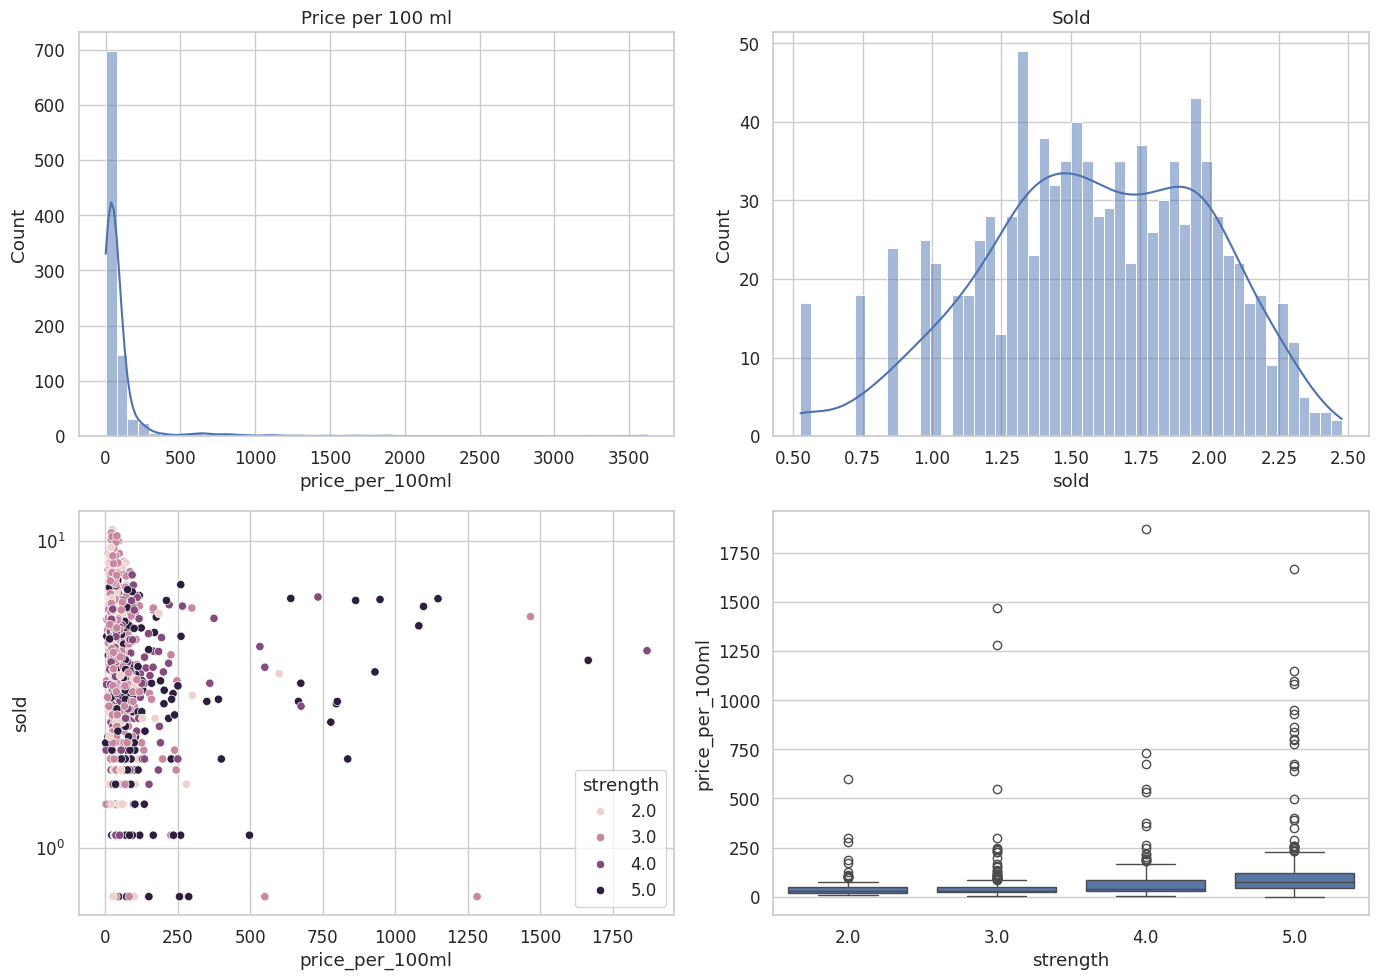

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(cluster_df['price_per_100ml'], bins=50, ax=axes[0,0], kde=True)
axes[0,0].set_title('Price per 100 ml')
sns.histplot(np.log1p(cluster_df['sold']), bins=50, ax=axes[0,1], kde=True)
axes[0,1].set_title('Sold')
sns.scatterplot(data=cluster_df, x='price_per_100ml', y='sold', hue='strength', ax=axes[1,0])
axes[1,0].set_yscale('log')
sns.boxplot(data=cluster_df, x='strength', y='price_per_100ml', ax=axes[1,1])
plt.tight_layout()
plt.show()

PRE-PROCESSING FOR CLUSTERING

(impute median → robust scale)

In [26]:
features = ['price_per_100ml', 'sold', 'strength']
X = df[features].dropna()

print("\nFinal clustering dataset shape:", X.shape)
print(X.describe())


Final clustering dataset shape: (904, 3)
       price_per_100ml          sold    strength
count       904.000000    904.000000  904.000000
mean         78.916504    795.750000    3.519912
std         157.461439   3281.557398    0.946897
min           0.894083      1.000000    2.000000
25%          25.755040     15.000000    3.000000
50%          38.016180     51.000000    3.000000
75%          72.541215    352.000000    4.000000
max        1868.750000  54052.000000    5.000000


In [27]:
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imp)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"After imputation & scaling: {X_scaled.shape[0]} rows")

After imputation & scaling: 904 rows


 PRE-PROCESSING PIPELINE

 (impute to scale numeric)

In [28]:
numeric_features = cluster_cols
categorical_features = ['country_cat']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_processed = preprocessor.fit_transform(X_raw)
print(f"Final feature matrix: {X_processed.shape}")

Final feature matrix: (1000, 13)


In [29]:
# DIMENSIONALITY REDUCTION: PCA + t-SNE
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA variance explained: {pca.explained_variance_ratio_.sum():.1%}")

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, learning_rate=300)
X_tsne = tsne.fit_transform(X_scaled)
print(f"t-SNE completed (KL = {tsne.kl_divergence_:.3f})")

PCA variance explained: 99.2%
t-SNE completed (KL = 0.276)


CLUSTERING: K-Means, Hierarchical, DBSCAN + Evaluation

In [30]:
results = []
# KMeans
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_processed)
results.append({'method': 'KMeans', 'silhouette': silhouette_score(X_processed, labels_km), 'DB': davies_bouldin_score(X_processed, labels_km)})

# Hierarchical (Ward)
hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels_hc = hc.fit_predict(X_processed)
results.append({'method': 'Hierarchical (ward)',
                'silhouette': silhouette_score(X_processed, labels_hc),
                'DB': davies_bouldin_score(X_processed, labels_hc)})

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_db = dbscan.fit_predict(X_processed)
if len(set(labels_db)) > 1 and -1 in labels_db:
    sil_db = silhouette_score(X_processed[labels_db != -1], labels_db[labels_db != -1])
    results.append({'method': 'DBSCAN', 'silhouette': sil_db, 'DB': np.nan})
elif len(set(labels_db)) > 1:
    results.append({'method': 'DBSCAN', 'silhouette': silhouette_score(X_processed, labels_db), 'DB': davies_bouldin_score(X_processed, labels_db)})
else:
    results.append({'method': 'DBSCAN', 'silhouette': np.nan, 'DB': np.nan})

eval_df = pd.DataFrame(results).round(4)
print("\n=== CLUSTERING EVALUATION ===")
display(eval_df.sort_values('silhouette', ascending=False))


=== CLUSTERING EVALUATION ===


,method,silhouette,DB
0,KMeans,0.8273,0.5172
1,Hierarchical (ward),0.8112,0.5337
2,DBSCAN,0.3791,NaN


In [31]:
# The kmeans.cluster_centers_ originate from X_processed.
numerical_scaler = preprocessor.named_transformers_['num'].named_steps['scaler']
numerical_centroids = kmeans.cluster_centers_[:, :len(cluster_cols)]
inverse_transformed_numerical_centroids = numerical_scaler.inverse_transform(numerical_centroids)

centroids = pd.DataFrame(
    inverse_transformed_numerical_centroids,
    columns=cluster_cols, # Use cluster_cols as these were the numerical features
    index=[f'Cluster {i}' for i in range(len(kmeans.cluster_centers_))]
).round(2)

print("\nCLUSTER CENTROIDS (REAL BUSINESS SEGMENTS):")
print(centroids)


CLUSTER CENTROIDS (REAL BUSINESS SEGMENTS):
           price_per_100ml      sold  strength
Cluster 0            58.07    255.99      3.48
Cluster 1            34.31  30086.75      2.88
Cluster 2           971.08    179.31      4.10
Cluster 3            28.90   6673.83      2.76


In [32]:
df['cluster'] = labels_km

K-MEANS + SILHOUETTE (ELBOW PLOT)

K Means

In [33]:
# Re-define PCA to be consistent with the data used for K-Means (X_processed)
pca_for_kmeans_plot = PCA(n_components=2, random_state=42)
X_pca_for_kmeans_plot = pca_for_kmeans_plot.fit_transform(X_processed)

# Project the K-Means centroids into this same PCA space.
centroids_pca = pca_for_kmeans_plot.transform(kmeans.cluster_centers_)

# Update plot_df to use these new, consistent PCA components.
plot_df = pd.DataFrame({
    'PC1'     : X_pca_for_kmeans_plot[:, 0],
    'PC2'     : X_pca_for_kmeans_plot[:, 1],
    'sold'    : df['sold'].values,
    'Cluster' : df['cluster'].values
})

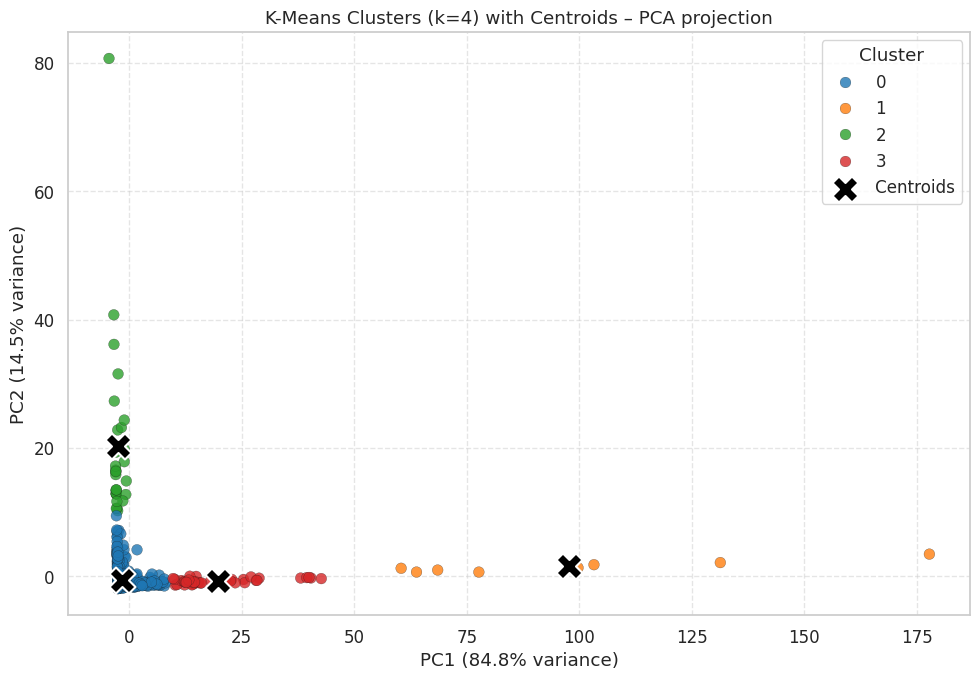

In [34]:
# Assuming k_opt was determined to be 6 from previous elbow/silhouette analysis
k_opt = 4

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df,
    x='PC1', y='PC2',
    hue='Cluster', palette='tab10',
    s=60, alpha=0.8, edgecolor='k', linewidth=0.2
)

# Centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    s=350, c='black', marker='X', label='Centroids',
    edgecolor='white', linewidth=1.5
)

plt.title(f'K-Means Clusters (k={k_opt}) with Centroids – PCA projection')
plt.xlabel(f'PC1 ({pca_for_kmeans_plot.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_for_kmeans_plot.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

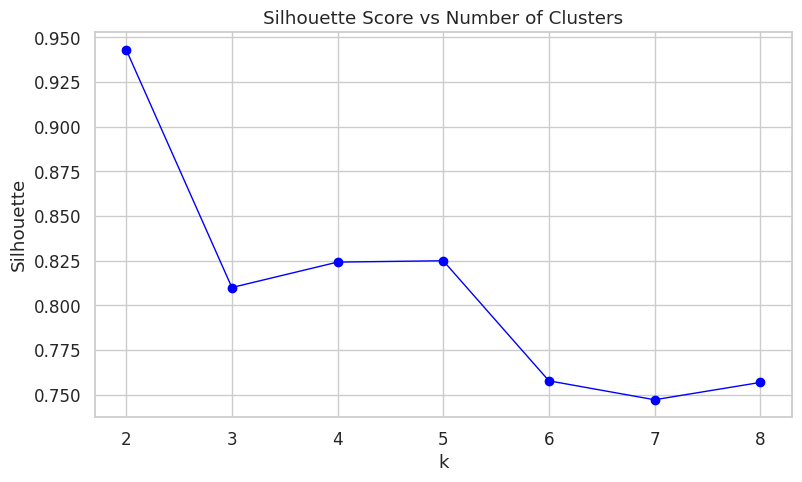

8
[np.float64(0.9431372624515745), np.float64(0.8100540522619605), np.float64(0.8242852425912829), np.float64(0.8250350600573454), np.float64(0.7578322162309312), np.float64(0.7472408589773729), np.float64(0.7569357677013597)]


In [35]:
sil = []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labs))

plt.figure(figsize=(9,5))
plt.plot(K, sil, marker='o', color='blue', linewidth=1)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)

plt.show()

print(k)
print(sil)

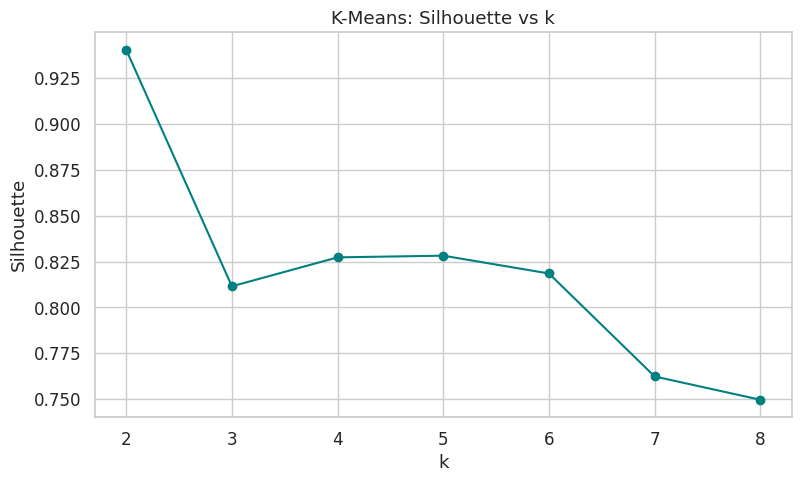

8
[np.float64(0.9404501100062639), np.float64(0.8115442677493493), np.float64(0.8273104308364447), np.float64(0.8282346981700475), np.float64(0.818533732134809), np.float64(0.7624191459113518), np.float64(0.7497210721215806)]


In [36]:
results = []

# K-Means (elbow + silhouette)
sil_scores = []
K = range(2, 9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_processed)
    sil = silhouette_score(X_processed, labs)
    db = davies_bouldin_score(X_processed, labs)
    sil_scores.append(sil)
    results.append({'method': f'KMeans k={k}', 'silhouette': sil, 'DB': db})

plt.figure(figsize=(9,5))
plt.plot(K, sil_scores, marker='o', color='teal')
plt.title('K-Means: Silhouette vs k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

print(k)
print(sil_scores)

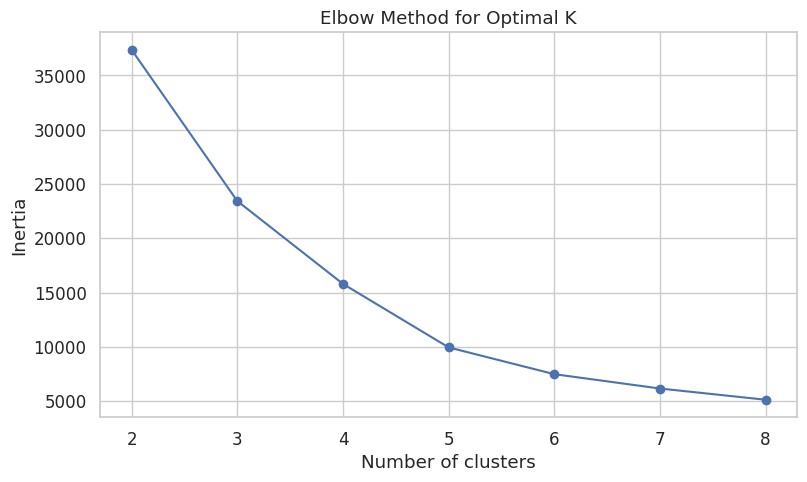

In [37]:
imputer_kmeans = SimpleImputer(strategy='median')
X_scaled_imputed = imputer_kmeans.fit_transform(X_scaled_df)

inertias = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_imputed)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(9,5))
plt.plot(range(2, 9), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()



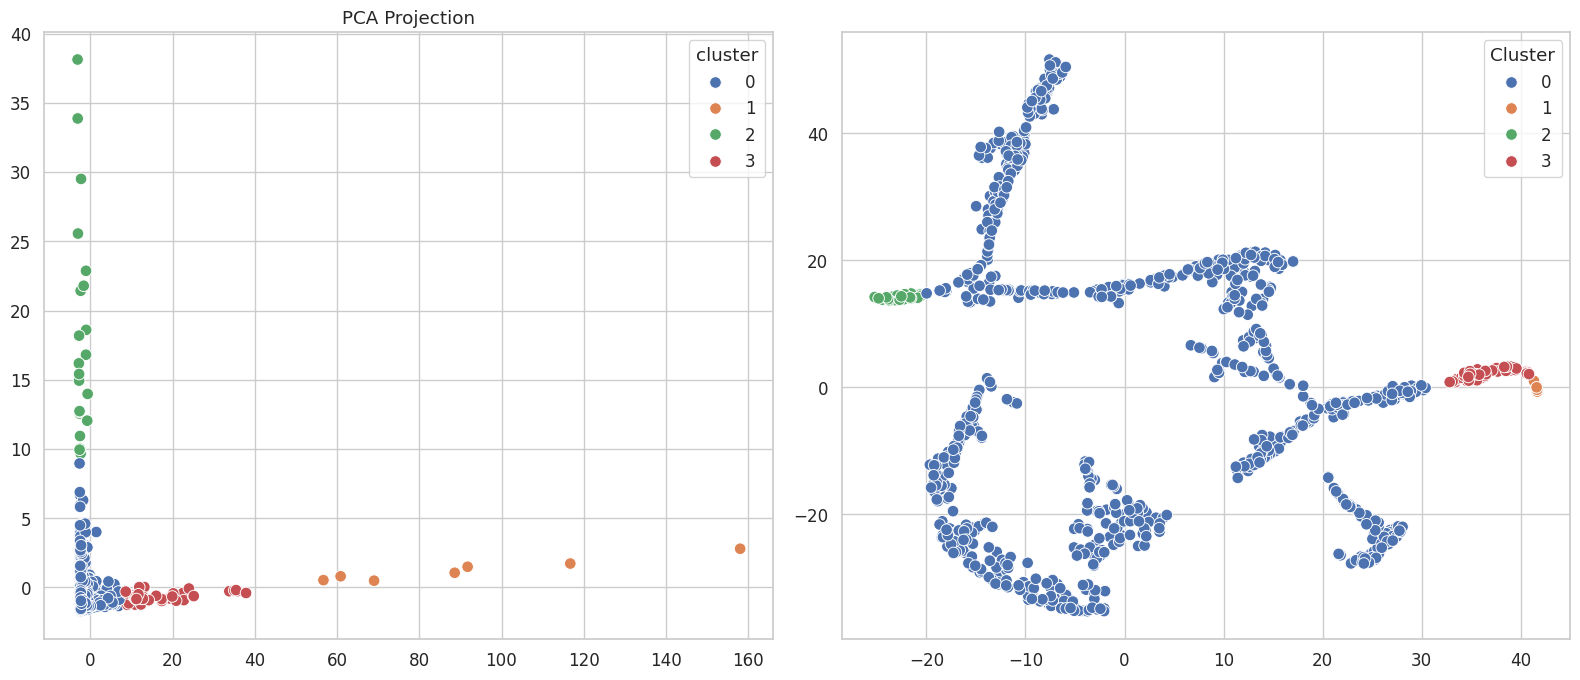

In [38]:
# Plot 6: PCA + t-SNE
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df.loc[X.index, 'cluster'], palette='deep', ax=ax1, s=70)
ax1.set_title('PCA Projection')
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df.loc[X.index, 'cluster'], palette='deep', ax=ax2, s=70)
ax2.legend(title='Cluster', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

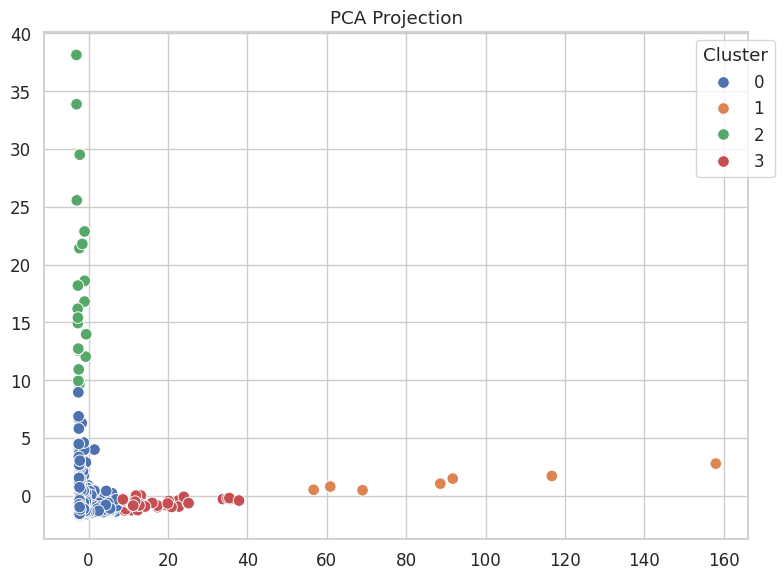

In [39]:
# PCA Projection
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df.loc[X.index, 'cluster'],
    palette='deep',
    s=70
)
plt.title('PCA Projection')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

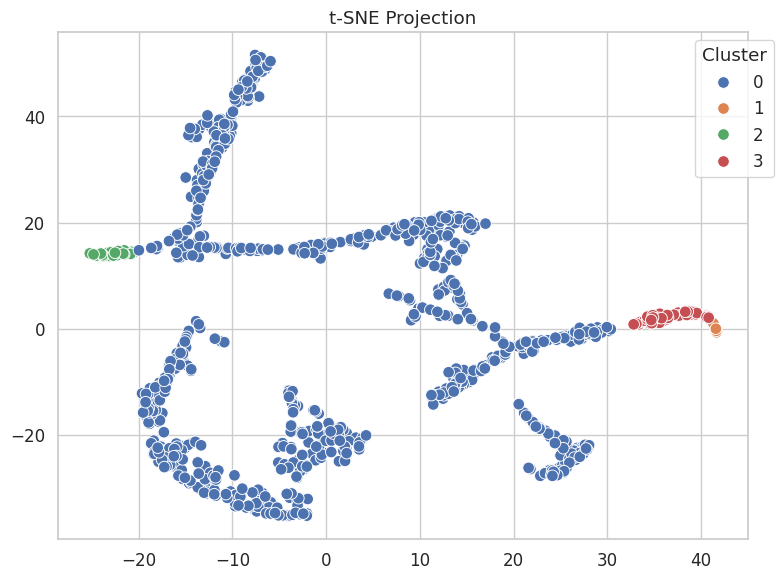

In [40]:
# t-SNE Projection
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=df.loc[X.index, 'cluster'],
    palette='deep',
    s=70
)
plt.title('t-SNE Projection')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [41]:
profile = df.groupby('cluster')[cluster_cols].agg(['mean','median']).round(2)
profile.columns = ['_'.join(c) for c in profile.columns]
profile = profile.reset_index()

seg_names = {0:'Budget / Clone', 1:'Mainstream Designer',
             2:'Premium / Niche', 3:'Ultra-Luxury'}
profile['Segment'] = profile['cluster'].map(seg_names)
profile

,cluster,price_per_100ml_mean,price_per_100ml_median,sold_mean,sold_median,strength_mean,strength_median,Segment
0,0,59.50,38.63,257.35,43.0,3.50,3.0,Budget / Clone
1,1,34.31,30.22,30086.75,27351.5,2.86,3.0,Mainstream Designer
2,2,971.08,796.67,179.31,41.0,4.39,5.0,Premium / Niche
3,3,28.66,26.56,6673.83,5302.0,2.76,3.0,Ultra-Luxury


Test Codes

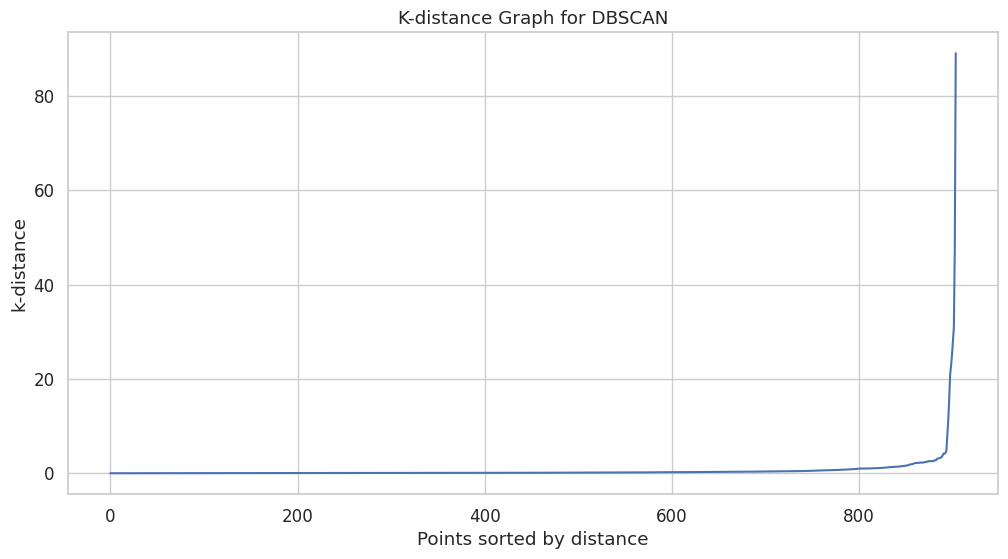

In [42]:
# KNN
n_features = X_scaled_imputed.shape[1]
min_samples_dbscan = 2 * n_features
k = min_samples_dbscan - 1

neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled_imputed)

distances, indices = neigh.kneighbors(X_scaled_imputed)

k_distances = distances[:, -1]

k_distances_sorted = np.sort(k_distances)

plt.figure(figsize=(12, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('K-distance Graph for DBSCAN')
plt.grid(True)
plt.show()

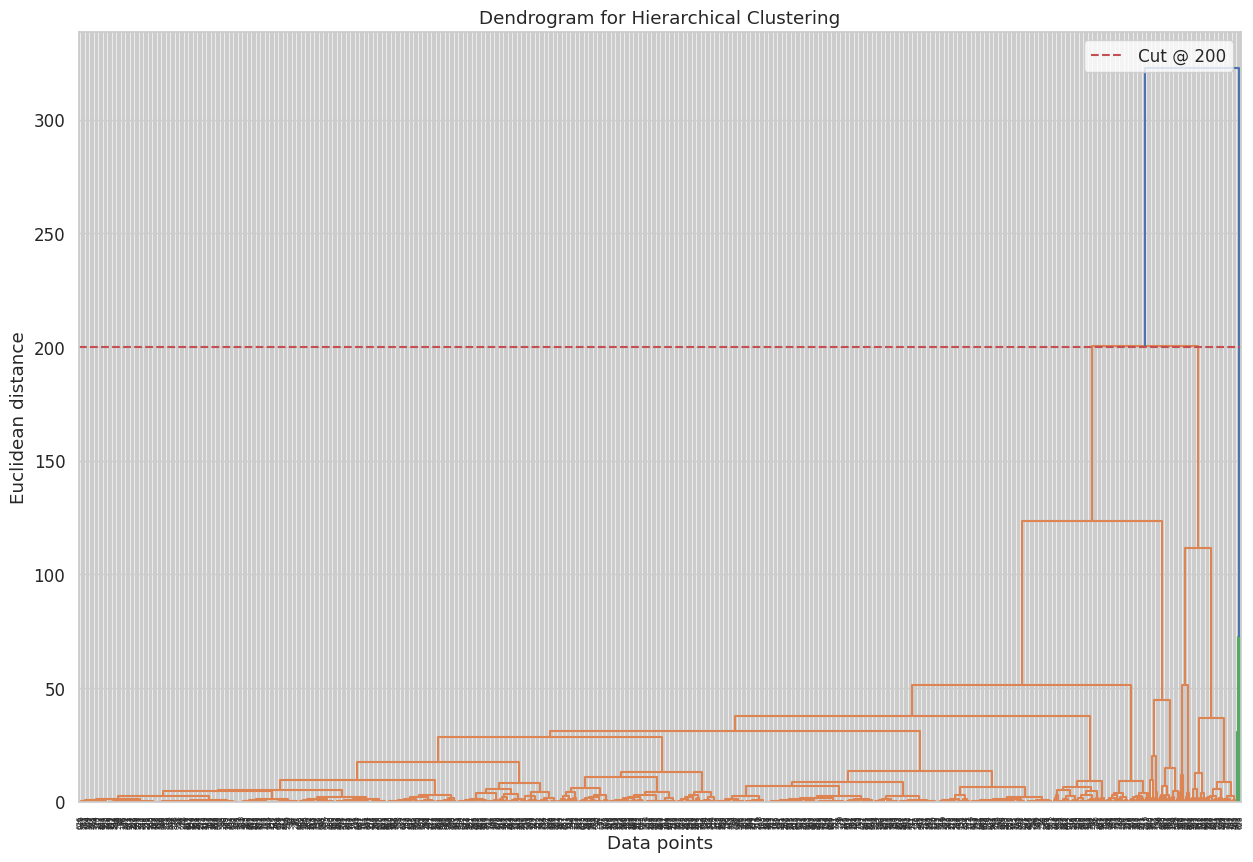

In [43]:
# Compute the linkage matrix using the ward method
linked = linkage(X_scaled_imputed, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data points')
plt.ylabel('Euclidean distance')

cut_distance = 200
plt.axhline(y=cut_distance, color='r', linestyle='--', label=f'Cut @ {cut_distance}')
plt.legend()
plt.show()

In [46]:
# --- K-Means Scores ---
print("--- K-Means Clustering Scores (k=4) ---")
# Get labels and data for evaluation. Use X_scaled_df.index to ensure alignment.
kmeans_labels = df.loc[X_scaled_df.index, 'cluster_kmeans'] # Using 'cluster_kmeans' as defined in _NFFNfTpBklX
kmeans_data_for_eval = X_scaled_imputed # This is the array that was clustered

# Filter out any potential NaNs from the labels (though they should not be there if assigned correctly)
valid_label_indices = ~kmeans_labels.isna()
kmeans_labels_for_eval = kmeans_labels[valid_label_indices].values # Get non-NaN labels
kmeans_data_for_eval_filtered = kmeans_data_for_eval[valid_label_indices] # Filter corresponding data

if len(np.unique(kmeans_labels_for_eval)) > 1:
    print(f"Davies-Bouldin Index: {davies_bouldin_score(kmeans_data_for_eval_filtered, kmeans_labels_for_eval):.3f}")
    print(f"Silhouette Score: {silhouette_score(kmeans_data_for_eval_filtered, kmeans_labels_for_eval):.3f}")
else:
    print("Not enough clusters (excluding NaN) to compute K-Means scores.")

# --- DBSCAN Scores ---
print("\n--- DBSCAN Clustering Scores ---")
# Get labels and data for evaluation. Use X_scaled_df.index to ensure alignment.
dbscan_labels = df.loc[X_scaled_df.index, 'cluster_dbscan']

# Filter out noise points (-1) and any NaNs from the labels and corresponding data
valid_dbscan_indices = (dbscan_labels != -1) & (~dbscan_labels.isna())
dbscan_labels_for_eval = dbscan_labels[valid_dbscan_indices].values
dbscan_data_for_eval_filtered = X_scaled_imputed[valid_dbscan_indices]

if len(np.unique(dbscan_labels_for_eval)) > 1:
    print(f"Davies-Bouldin Index: {davies_bouldin_score(dbscan_data_for_eval_filtered, dbscan_labels_for_eval):.3f}")
    print(f"Silhouette Score: {silhouette_score(dbscan_data_for_eval_filtered, dbscan_labels_for_eval):.3f}")
else:
    print("Not enough clusters (excluding noise and NaN) to compute DBSCAN scores.")

# --- Hierarchical Clustering Scores ---
print("\n--- Hierarchical Clustering Scores (k=4) ---")
# Get labels and data for evaluation. Use X_scaled_df.index to ensure alignment.
hierarchical_labels = df.loc[X_scaled_df.index, 'cluster_hierarchical']

# Filter out any potential NaNs from the labels
valid_hierarchical_indices = ~hierarchical_labels.isna()
hierarchical_labels_for_eval = hierarchical_labels[valid_hierarchical_indices].values
hierarchical_data_for_eval_filtered = X_scaled_imputed[valid_hierarchical_indices]

if len(np.unique(hierarchical_labels_for_eval)) > 1:
    print(f"Davies-Bouldin Index: {davies_bouldin_score(hierarchical_data_for_eval_filtered, hierarchical_labels_for_eval):.3f}")
    print(f"Silhouette Score: {silhouette_score(hierarchical_data_for_eval_filtered, hierarchical_labels_for_eval):.3f}")
else:
    print("Not enough clusters (excluding NaN) to compute Hierarchical scores.")

--- K-Means Clustering Scores (k=4) ---
Davies-Bouldin Index: 0.397
Silhouette Score: 0.810

--- DBSCAN Clustering Scores ---
Davies-Bouldin Index: 0.234
Silhouette Score: 0.805

--- Hierarchical Clustering Scores (k=4) ---
Davies-Bouldin Index: 0.504
Silhouette Score: 0.823


**K Means**

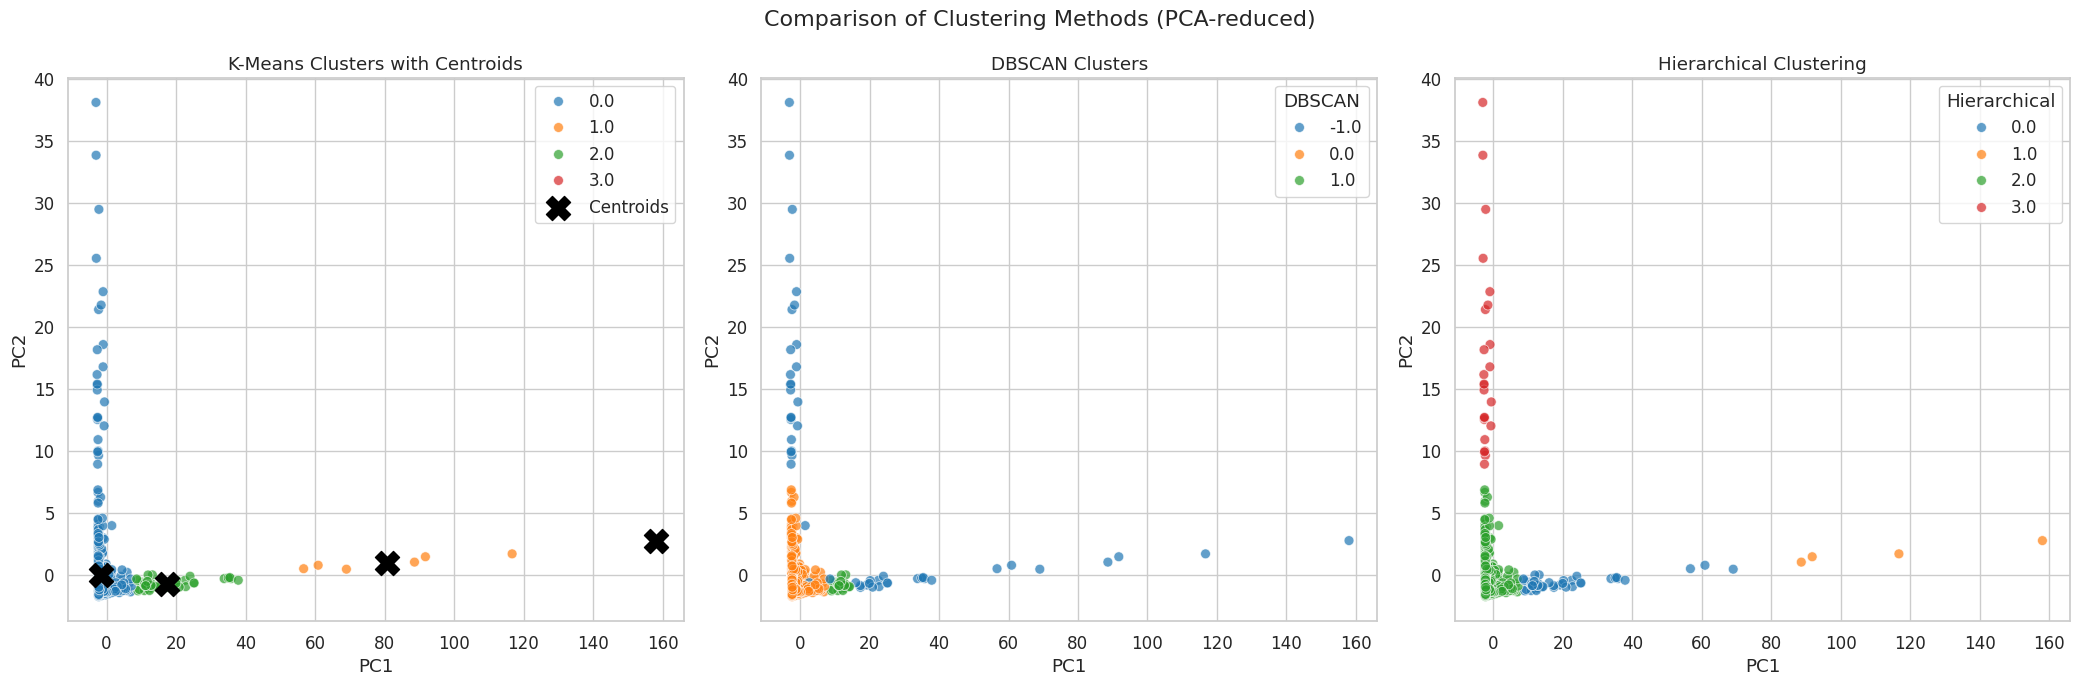

In [45]:
# Clustering Models
# KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df.loc[X_scaled_df.index, 'cluster_kmeans'] = kmeans.fit_predict(X_scaled_df)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
df.loc[X_scaled_df.index, 'cluster_dbscan'] = dbscan.fit_predict(X_scaled_df)

# Hierarchical
hier = AgglomerativeClustering(n_clusters=4, linkage='ward')
df.loc[X_scaled_df.index, 'cluster_hierarchical'] = hier.fit_predict(X_scaled_df)

# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_scaled_df.index)

plot_df['KMeans'] = df.loc[X_scaled_df.index, 'cluster_kmeans']
plot_df['DBSCAN'] = df.loc[X_scaled_df.index, 'cluster_dbscan']
plot_df['Hierarchical'] = df.loc[X_scaled_df.index, 'cluster_hierarchical']

# Prepare centroids (KMeans only)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# KMeans plot
sns.scatterplot(ax=axes[0], data=plot_df, x='PC1', y='PC2', hue='KMeans', palette='tab10', s=50, alpha=0.7)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='black', marker='X', label='Centroids')
axes[0].set_title('K-Means Clusters with Centroids')
axes[0].legend()

# DBSCAN plot
sns.scatterplot(ax=axes[1], data=plot_df, x='PC1', y='PC2', hue='DBSCAN', palette='tab10', s=50, alpha=0.7)
axes[1].set_title('DBSCAN Clusters')

# Hierarchical plot
sns.scatterplot(ax=axes[2], data=plot_df, x='PC1', y='PC2', hue='Hierarchical', palette='tab10', s=50, alpha=0.7)
axes[2].set_title('Hierarchical Clustering')

plt.suptitle('Comparison of Clustering Methods (PCA-reduced)', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Save the updated DataFrame to a CSV file
df.to_csv('updated_fragrance_dataset.csv', index=False)

print("Updated dataset saved to 'updated_fragrance_dataset.csv'")
print("You can download this file from the Colab file browser (left-hand sidebar).")